# RNN model with normal or fixed sign updates

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline
from matplotlib import rcParams

# rcParams['figure.figsize'] = [20, 4]
# rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Define model and optimizers

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, n_layer: int = 1, fixed_sign: bool = False):
        super(RNN,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layer = n_layer

        self.rnn = nn.RNN(input_size, hidden_size, n_layer, batch_first=True, nonlinearity='relu')
        self.fc = nn.Linear(hidden_size, output_size)

        # Turn into fixed sign (obey Dale's law)
        with torch.no_grad():
            self.fixed_sign = fixed_sign
            pos_neurons = {}
            neg_neurons = {}
            if fixed_sign:
                for name, param in self.named_parameters():
                    if "weight" in name:
                        # Find each neuron is excitatory or inhibitory
                        pos_neurons[name] = torch.sum(param.data, axis=0) >= 0
                        neg_neurons[name] = torch.sum(param.data, axis=0) < 0
                        # Make all weights of that neuron excitatory or inhibitory
                        param.data[:,pos_neurons[name]] = torch.sign(param[:,pos_neurons[name]])*param[:,pos_neurons[name]]
                        param.data[:,neg_neurons[name]] = -torch.sign(param[:,neg_neurons[name]])*param[:,neg_neurons[name]]

        # Store original weights information
        self.pos_neurons = pos_neurons
        self.neg_neurons = neg_neurons
     
    def forward(self, input):
        # Initialize hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.n_layer, input.size(0), self.hidden_size).requires_grad_()

        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        hidden, _ = self.rnn(input, h0.detach())

        # Output = hidden state of last time step
        output = self.fc(hidden[:, -1, :])
        
        return output
        
    def init_zero_hidden(self, batch_size=1):
        """
        Returns a hidden state with specified batch size. Defaults to 1
        """
        return torch.zeros(batch_size, self.hidden_size, requires_grad=False)

In [10]:
class gd(torch.optim.Optimizer): 
    def __init__(self, params, lr=0.01, fixed_sign: bool = False): 
        defaults = dict(lr=lr, fixed_sign=fixed_sign) 
        super(gd, self).__init__(params, defaults) 
  
    def step(self, init_weights=None): 
        for group in self.param_groups: 
            for i, p in enumerate(group['params']): 
                if p.grad is None: 
                    continue
                p.data = p.data - group['lr']*p.grad.data

                if group['fixed_sign']:
                    flip_mask = init_weights[i].sign()*p.data.sign()<0
                    p.data[flip_mask] = 0

In [11]:
class adam(torch.optim.Optimizer): 
	def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, fixed_sign: bool = False): 
		defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, fixed_sign=fixed_sign)
		super(adam, self).__init__(params, defaults) 

	def step(self, init_weights=None): 
		for group in self.param_groups: 
			for i, p in enumerate(group['params']): 
				if p.grad is None: 
					continue
				grad = p.grad.data 
				if grad.is_sparse: 
					raise RuntimeError("Adam does not support sparse gradients") 

				state = self.state[p] 

				# State initialization 
				if len(state) == 0: 
					state["step"] = 0
					# Momentum: Exponential moving average of gradient values 
					state["exp_avg"] = torch.zeros_like(p.data) 
					# RMS prop componenet: Exponential moving average of squared gradient values 
					state["exp_avg_sq"] = torch.zeros_like(p.data) 

				exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"] 
				beta1, beta2 = group["betas"] 
				state["step"] += 1

				if group['weight_decay'] != 0: 
					grad = grad.add(p.data, alpha=group['weight_decay']) 

				# Decay the first and second moment running average coefficient
				exp_avg.lerp_(grad, 1 - beta1) # momentum
				exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1-beta2) # rms
			
				bias_correction1 = 1 - beta1 ** state["step"] 
				bias_correction2 = 1 - beta2 ** state["step"] 

				step_size = group["lr"] / bias_correction1
				bias_correction2_sqrt = math.sqrt(bias_correction2)

				denom = (exp_avg_sq.sqrt() / bias_correction2_sqrt).add_(group["eps"])

				p.data.addcdiv_(exp_avg, denom, value=-step_size)
				
				if group["fixed_sign"]: 
					flip_mask = init_weights[i].sign()*p.data.sign()<0
					p.data[flip_mask] = 0

In [12]:
#@title Downloading MNIST data

train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

# val_data = dsets.MNIST(root = './data', train=False,
#                        transform=transforms.ToTensor(), download=True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

#@title Loading the data
batch_size = 100 # the size of input data took for one iteration

train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

## Train RNN model

In [13]:
input_size = 28 # img_size = (28,28) ---> 28*28=784 in total
hidden_size = 100 # number of nodes at hidden layer
output_size = 10 # number of output classes discrete range [0,9]
num_epochs = 5 # 20 # number of times which the entire dataset is passed throughout the model
lr = 1e-3 # size of step

In [14]:
corelease_net = RNN(input_size,hidden_size,output_size,fixed_sign=False)
if torch.cuda.is_available():
  corelease_net.cuda()

# Initalize training details
loss_function = nn.CrossEntropyLoss()
# optimizer = gd(net.parameters(), lr=lr)
optimizer = adam(corelease_net.parameters(), lr=lr)
training_loss = []

rnn.weight_ih_l0
 Positive: 49.964284896850586%; Negative: 50.035715103149414%; Zero: 0.0%
rnn.weight_hh_l0
 Positive: 50.349998474121094%; Negative: 49.64999854564667%; Zero: 0.0%
rnn.bias_ih_l0
 Positive: 56.00000023841858%; Negative: 43.99999976158142%; Zero: 0.0%
rnn.bias_hh_l0
 Positive: 50.0%; Negative: 50.0%; Zero: 0.0%
fc.weight
 Positive: 51.499998569488525%; Negative: 48.500001430511475%; Zero: 0.0%
fc.bias
 Positive: 20.000000298023224%; Negative: 80.0000011920929%; Zero: 0.0%


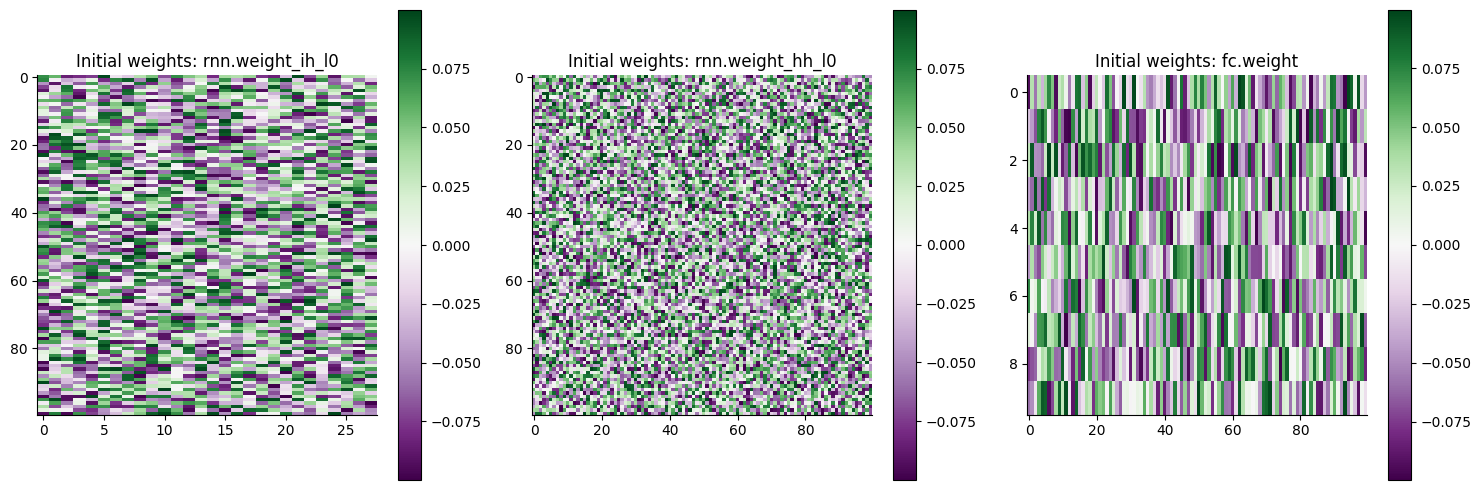

In [15]:
# Save the initial weights
initial_params_corelease = {}
for name, param in corelease_net.named_parameters():
    if param.requires_grad:
      print(name)
      with torch.no_grad():
        cur_data = param.data.detach().cpu().clone()
        initial_params_corelease[name] = (cur_data)
      
      frac_pos = 100*(torch.sum(cur_data > 0)/cur_data.numel()).numpy()
      frac_zero = 100*(torch.sum(cur_data == 0)/cur_data.numel()).numpy()
      frac_neg = 100*(torch.sum(cur_data < 0)/cur_data.numel()).numpy()
      print(' Positive: ' + str(frac_pos) + '%; Negative: ' + str(frac_neg) + '%; Zero: ' + str(frac_zero) + '%')

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_corelease)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in initial_params_corelease.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0])
    axs[ax].set_title('Initial weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

Iteration: 500. Loss: 0.38355404138565063. Accuracy: 84.62000274658203
Iteration: 1000. Loss: 0.4515128433704376. Accuracy: 88.55000305175781
Iteration: 1500. Loss: 0.17105001211166382. Accuracy: 90.93000030517578
Iteration: 2000. Loss: 0.1394425928592682. Accuracy: 92.91000366210938
Iteration: 2500. Loss: 0.2074132114648819. Accuracy: 93.61000061035156
Iteration: 3000. Loss: 0.143981471657753. Accuracy: 95.0199966430664


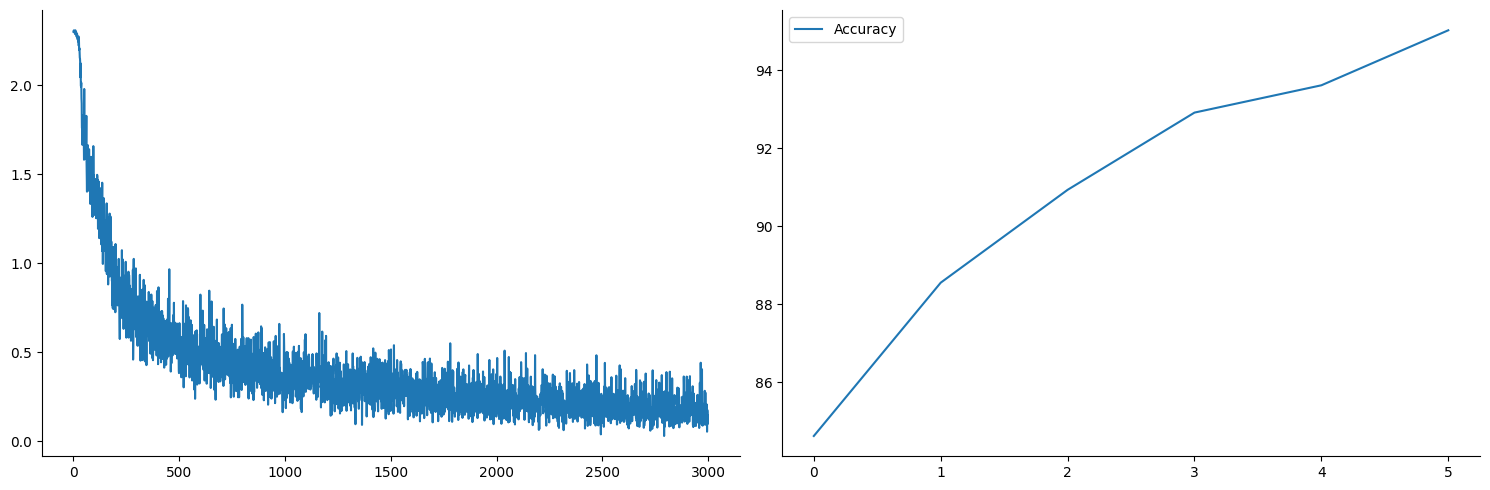

In [16]:
seq_dim = 28
iter = 0
training_loss = []
training_accuracy = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_gen):
        corelease_net.train()
        # Load images as tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_size).requires_grad_()

        optimizer.zero_grad()

        outputs = corelease_net(images)
        loss = loss_function(outputs, labels)
        training_loss.append(loss.data.cpu())

        loss.backward()
        optimizer.step()

        iter += 1
        if iter % 500 == 0:
            corelease_net.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_gen:
                images = images.view(-1, seq_dim, input_size)
                outputs = corelease_net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            training_accuracy.append(accuracy)

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


# Plot training loss history
fig, axs = plt.subplots(1,2,figsize=(15, 5))
axs[0].plot(training_loss, label='Loss')
axs[1].plot(training_accuracy, label='Accuracy')
plt.legend()

rnn.weight_ih_l0
 Positive: 51.99999809265137%; Negative: 47.999998927116394%; Zero: 0.0%
rnn.weight_hh_l0
 Positive: 51.889997720718384%; Negative: 48.10999929904938%; Zero: 0.0%
rnn.bias_ih_l0
 Positive: 50.0%; Negative: 50.0%; Zero: 0.0%
rnn.bias_hh_l0
 Positive: 46.00000083446503%; Negative: 54.00000214576721%; Zero: 0.0%
fc.weight
 Positive: 46.0999995470047%; Negative: 53.89999747276306%; Zero: 0.0%
fc.bias
 Positive: 30.000001192092896%; Negative: 69.9999988079071%; Zero: 0.0%


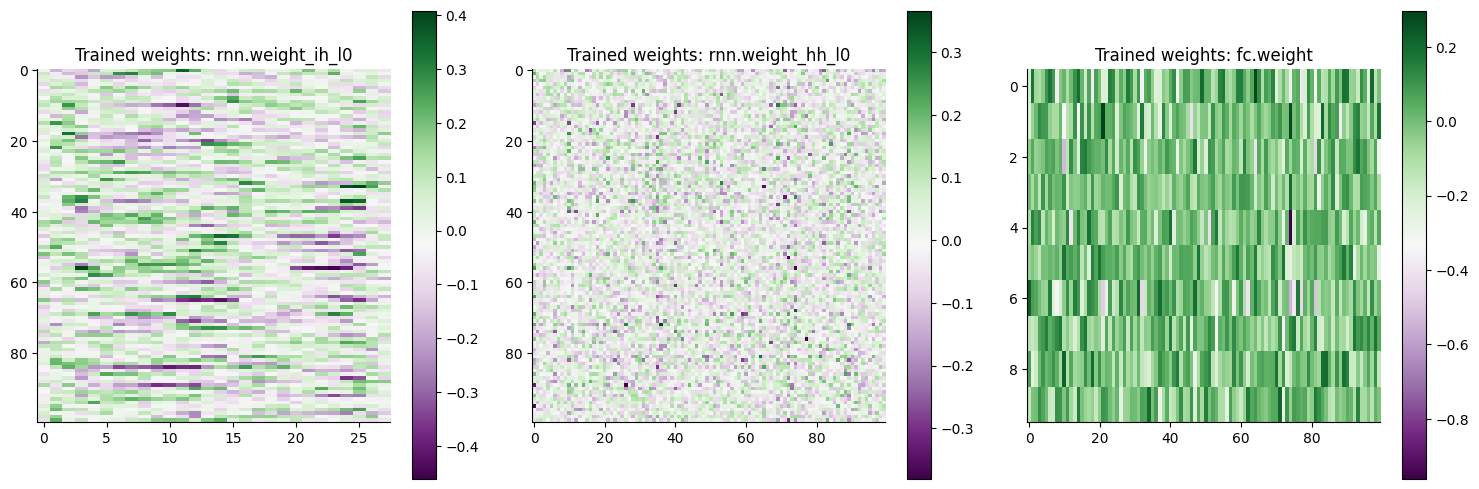

In [17]:
# Save the trianed parameters in paramList
trained_params_corelease = {}
for name, param in corelease_net.named_parameters():
    if param.requires_grad:
      print(name)
      with torch.no_grad():
        cur_data = param.data.detach().cpu().clone()
        trained_params_corelease[name] = (cur_data)
      
      frac_pos = 100*(torch.sum(cur_data > 0)/cur_data.numel()).numpy()
      frac_zero = 100*(torch.sum(cur_data == 0)/cur_data.numel()).numpy()
      frac_neg = 100*(torch.sum(cur_data < 0)/cur_data.numel()).numpy()
      print(' Positive: ' + str(frac_pos) + '%; Negative: ' + str(frac_neg) + '%; Zero: ' + str(frac_zero) + '%')

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(trained_params_corelease)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in trained_params_corelease.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0])
    axs[ax].set_title('Trained weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

rnn.weight_ih_l0 flipped:  27.536% (771/2800)
rnn.weight_hh_l0 flipped:  16.520% (1652/10000)
rnn.bias_ih_l0 flipped:  16.000% (16/100)
rnn.bias_hh_l0 flipped:  14.000% (14/100)
fc.weight flipped:  22.800% (228/1000)
fc.bias flipped:  30.000% (3/10)
rnn.weight_ih_l0 changed:  99.321% (2781/2800)
rnn.weight_hh_l0 changed:  99.790% (9979/10000)
rnn.bias_ih_l0 changed:  100.000% (100/100)
rnn.bias_hh_l0 changed:  100.000% (100/100)
fc.weight changed:  99.000% (990/1000)
fc.bias changed:  100.000% (10/10)


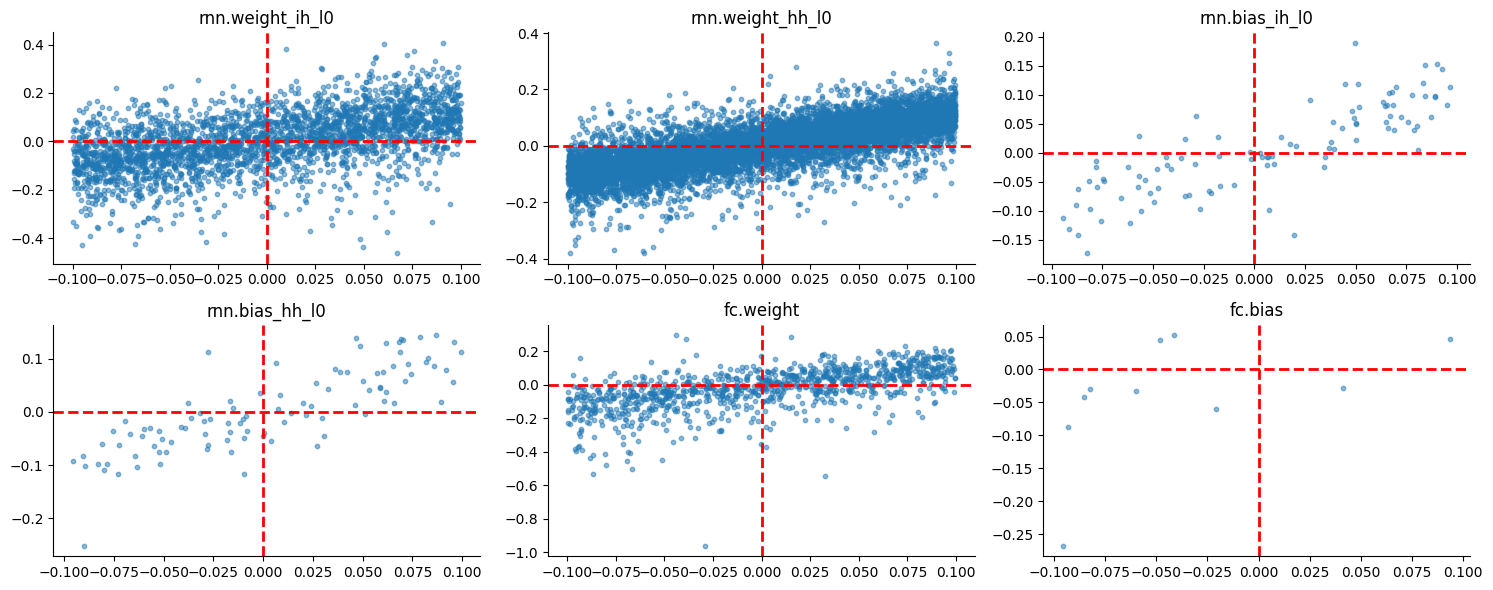

In [18]:
#@title What fraction of parameters flip sign?
for key in initial_params_corelease:
    n_weights=initial_params_corelease[key].numel()
    n_flip = (initial_params_corelease[key].sign()*trained_params_corelease[key].sign()<0).count_nonzero().item()
    print(key + ' flipped: % .3f%% (%d/%d)' %(100*n_flip/n_weights, n_flip, n_weights))

for key in initial_params_corelease:
    n_weights=initial_params_corelease[key].numel()
    n_changed = (initial_params_corelease[key] != trained_params_corelease[key]).count_nonzero().item()
    print(key + ' changed: % .3f%% (%d/%d)' %(100*n_changed/n_weights, n_changed, n_weights))

# Plot initial vs trained values

fig, axs = plt.subplots(2,int(len(trained_params_corelease)/2),figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)

ax = 0
for i, ax in enumerate(axs.flatten()):
    key = list(initial_params_corelease)[i]
    ax.scatter(initial_params_corelease[key].numpy(),trained_params_corelease[key].numpy(),s=10,alpha=0.5)
    ax.axhline(y=0, linewidth=2, color = 'r', ls='--')
    ax.axvline(x=0, linewidth=2, color = 'r', ls='--')
    ax.set_title(key)

plt.tight_layout()
plt.show()

## Fixed sign RNN model

In [19]:
fixed_sign_net = RNN(input_size,hidden_size,output_size,fixed_sign=True)
if torch.cuda.is_available():
  fixed_sign_net.cuda()

# Initalize training details
loss_function = nn.CrossEntropyLoss()
# optimizer = gd(fixed_sign_model.parameters(), lr=lr, fixed_sign=True)
fs_optimizer = adam(fixed_sign_net.parameters(), lr=lr, fixed_sign=True)

rnn.weight_ih_l0
 Positive: 42.85714328289032%; Negative: 57.14285969734192%; Zero: 0.0%
rnn.weight_hh_l0
 Positive: 46.00000083446503%; Negative: 54.00000214576721%; Zero: 0.0%
rnn.bias_ih_l0
 Positive: 50.999999046325684%; Negative: 49.000000953674316%; Zero: 0.0%
rnn.bias_hh_l0
 Positive: 46.00000083446503%; Negative: 54.00000214576721%; Zero: 0.0%
fc.weight
 Positive: 50.999999046325684%; Negative: 49.000000953674316%; Zero: 0.0%
fc.bias
 Positive: 30.000001192092896%; Negative: 69.9999988079071%; Zero: 0.0%


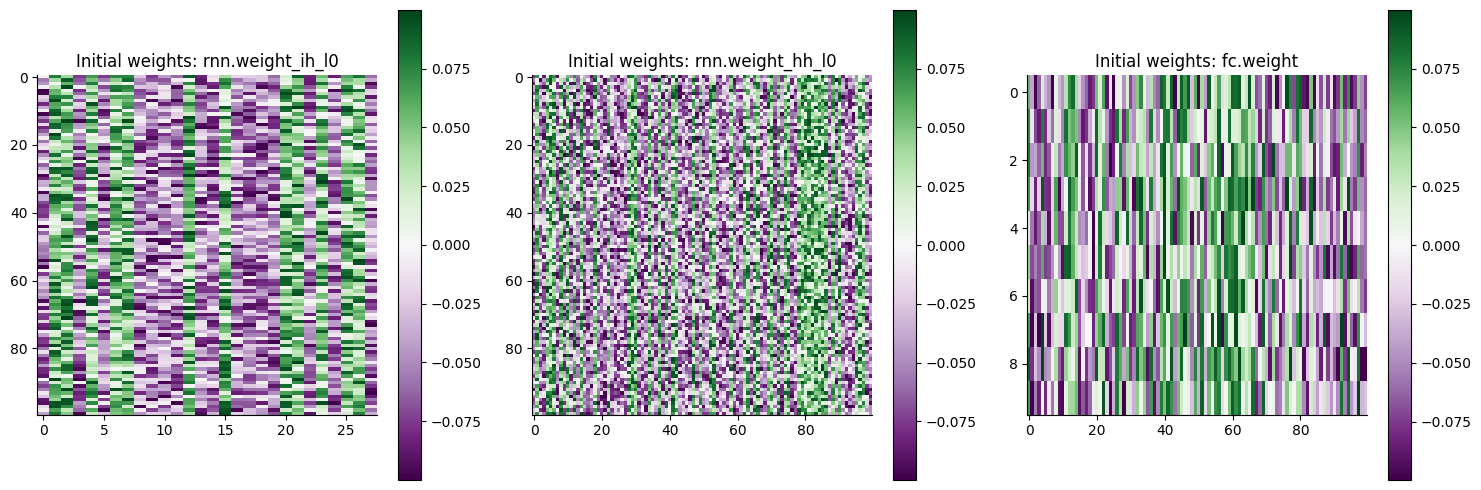

In [20]:
# Save the initial weights
initial_params_fixed = {}
for name, param in fixed_sign_net.named_parameters():
    if param.requires_grad:
      print(name)
      with torch.no_grad():
        cur_data = param.data.detach().cpu().clone()
        initial_params_fixed[name] = (cur_data)
      
      frac_pos = 100*(torch.sum(cur_data > 0)/cur_data.numel()).numpy()
      frac_zero = 100*(torch.sum(cur_data == 0)/cur_data.numel()).numpy()
      frac_neg = 100*(torch.sum(cur_data < 0)/cur_data.numel()).numpy()
      print(' Positive: ' + str(frac_pos) + '%; Negative: ' + str(frac_neg) + '%; Zero: ' + str(frac_zero) + '%')

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_fixed)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in initial_params_fixed.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0])
    axs[ax].set_title('Initial weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

In [21]:
seq_dim = 28
iter = 0
fs_training_loss = []
fs_training_accuracy = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_gen):
        fixed_sign_net.train()
        # Load images as tensors with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_size).requires_grad_()

        fs_optimizer.zero_grad()

        outputs = fixed_sign_net(images)
        loss = loss_function(outputs, labels)
        fs_training_loss.append(loss.data.cpu())

        loss.backward()
        fs_optimizer.step(init_weights=list(initial_params_fixed.values()))

        iter += 1
        if iter % 500 == 0:
            fixed_sign_net.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_gen:
                images = images.view(-1, seq_dim, input_size)
                outputs = fixed_sign_net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            fs_training_accuracy.append(accuracy)

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.1389391422271729. Accuracy: 58.970001220703125
Iteration: 1000. Loss: 0.6610432267189026. Accuracy: 78.38999938964844
Iteration: 1500. Loss: 0.36777564883232117. Accuracy: 86.13999938964844
Iteration: 2000. Loss: 0.340348482131958. Accuracy: 89.93000030517578
Iteration: 2500. Loss: 0.48586398363113403. Accuracy: 91.69999694824219
Iteration: 3000. Loss: 0.37732529640197754. Accuracy: 90.8499984741211


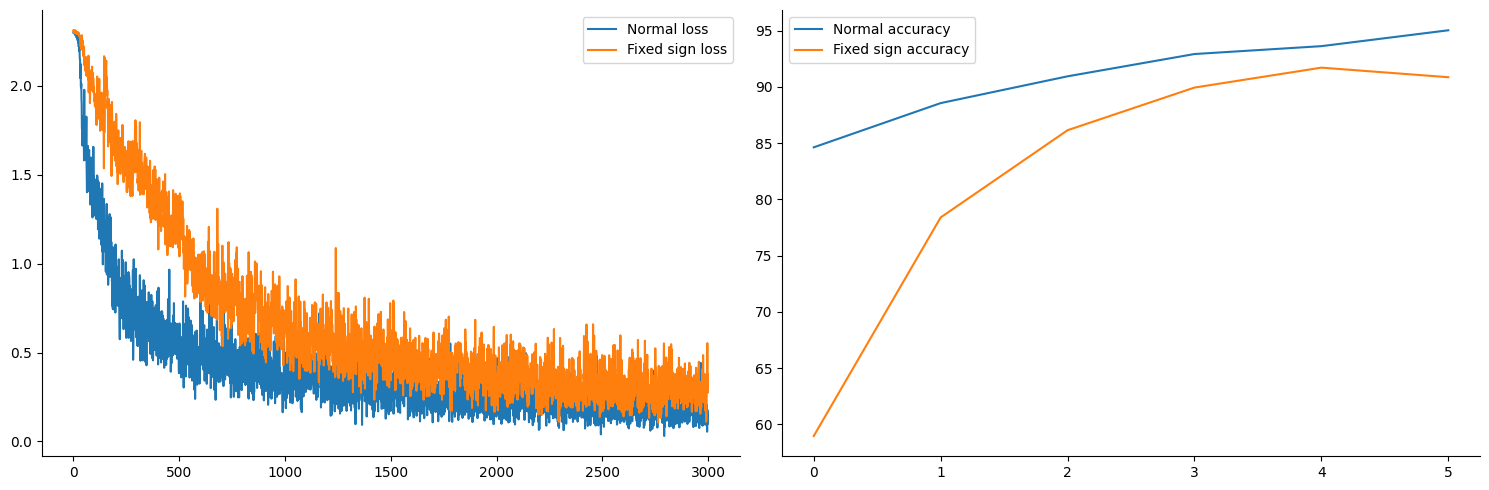

In [22]:
# Plot training loss history
fig, axs = plt.subplots(1,2,figsize=(15, 5))
axs[0].plot(training_loss, label='Normal loss')
axs[0].plot(fs_training_loss, label='Fixed sign loss')
axs[0].legend()
axs[1].plot(training_accuracy, label='Normal accuracy')
axs[1].plot(fs_training_accuracy, label='Fixed sign accuracy')
axs[1].legend()

rnn.weight_ih_l0
 Positive: 39.14285600185394%; Negative: 54.07142639160156%; Zero: 6.785714626312256%
rnn.weight_hh_l0
 Positive: 44.850000739097595%; Negative: 52.799999713897705%; Zero: 2.3499999195337296%
rnn.bias_ih_l0
 Positive: 50.999999046325684%; Negative: 47.999998927116394%; Zero: 0.9999999776482582%
rnn.bias_hh_l0
 Positive: 46.00000083446503%; Negative: 50.999999046325684%; Zero: 2.9999999329447746%
fc.weight
 Positive: 47.29999899864197%; Negative: 46.799999475479126%; Zero: 5.900000035762787%
fc.bias
 Positive: 20.000000298023224%; Negative: 60.00000238418579%; Zero: 20.000000298023224%


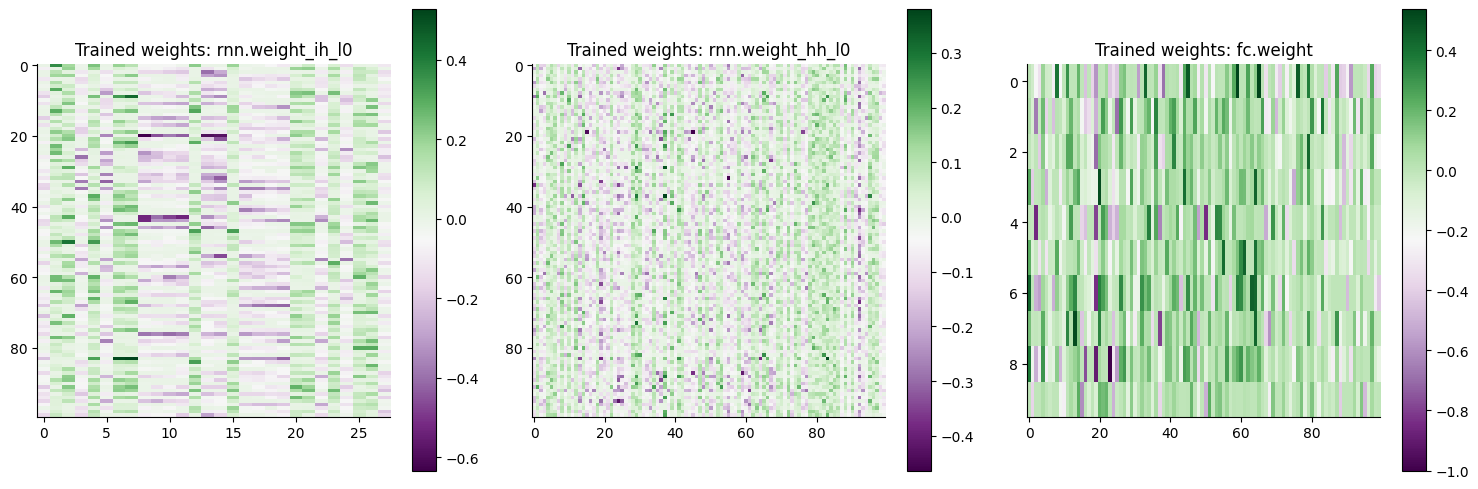

In [23]:
# Save the trianed parameters in paramList
trained_params_fixed = {}
for name, param in fixed_sign_net.named_parameters():
    if param.requires_grad:
      print(name)
      with torch.no_grad():
        cur_data = param.data.detach().cpu().clone()
        trained_params_fixed[name] = (cur_data)
      
      frac_pos = 100*(torch.sum(cur_data > 0)/cur_data.numel()).numpy()
      frac_zero = 100*(torch.sum(cur_data == 0)/cur_data.numel()).numpy()
      frac_neg = 100*(torch.sum(cur_data < 0)/cur_data.numel()).numpy()
      print(' Positive: ' + str(frac_pos) + '%; Negative: ' + str(frac_neg) + '%; Zero: ' + str(frac_zero) + '%')

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_fixed)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in trained_params_fixed.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0])
    axs[ax].set_title('Trained weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

rnn.weight_ih_l0 flipped:  0.000% (0/2800)
rnn.weight_hh_l0 flipped:  0.000% (0/10000)
rnn.bias_ih_l0 flipped:  0.000% (0/100)
rnn.bias_hh_l0 flipped:  0.000% (0/100)
fc.weight flipped:  0.000% (0/1000)
fc.bias flipped:  0.000% (0/10)
rnn.weight_ih_l0 changed:  99.714% (2792/2800)
rnn.weight_hh_l0 changed:  100.000% (10000/10000)
rnn.bias_ih_l0 changed:  100.000% (100/100)
rnn.bias_hh_l0 changed:  100.000% (100/100)
fc.weight changed:  100.000% (1000/1000)
fc.bias changed:  100.000% (10/10)


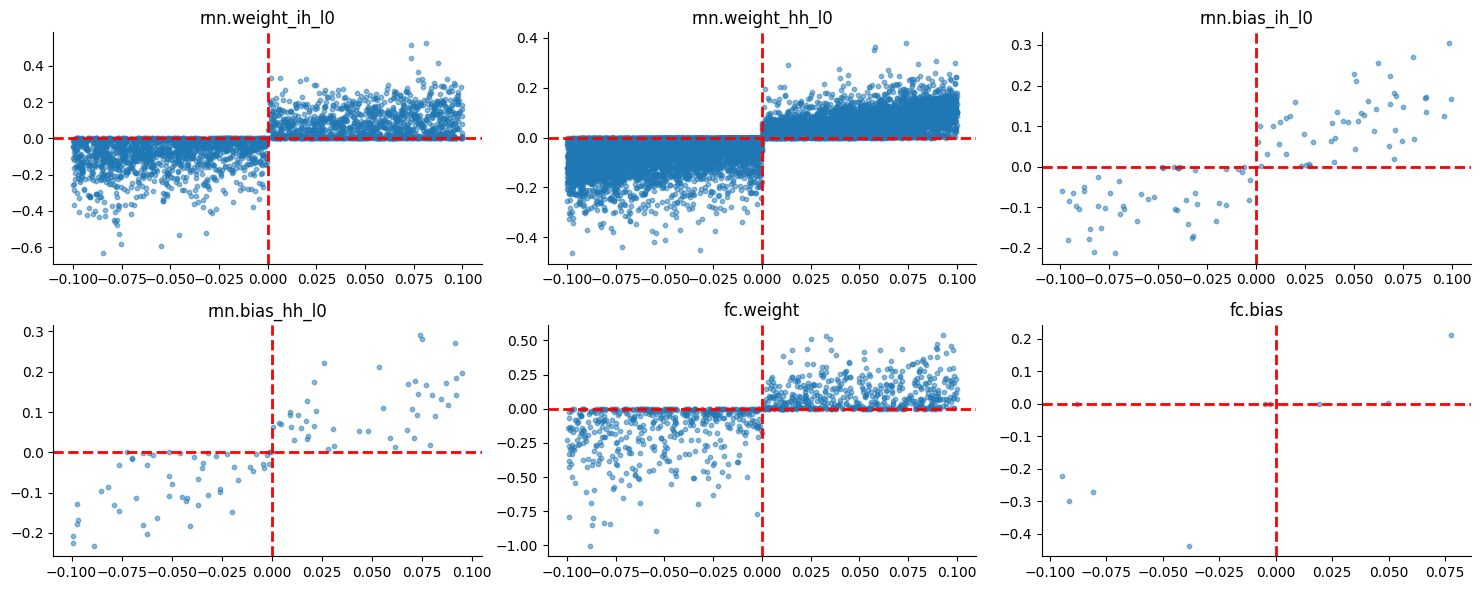

In [24]:
#@title What fraction of parameters flip sign?
for key in initial_params_fixed:
    n_weights=initial_params_fixed[key].numel()
    n_flip = (initial_params_fixed[key].sign()*trained_params_fixed[key].sign()<0).count_nonzero().item()
    print(key + ' flipped: % .3f%% (%d/%d)' %(100*n_flip/n_weights, n_flip, n_weights))

for key in initial_params_fixed:
    n_weights=initial_params_fixed[key].numel()
    n_changed = (initial_params_fixed[key] != trained_params_fixed[key]).count_nonzero().item()
    print(key + ' changed: % .3f%% (%d/%d)' %(100*n_changed/n_weights, n_changed, n_weights))

# Plot initial vs trained values

fig, axs = plt.subplots(2,int(len(trained_params_fixed)/2),figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)

ax = 0
for i, ax in enumerate(axs.flatten()):
    key = list(initial_params_fixed)[i]
    ax.scatter(initial_params_fixed[key].numpy(),trained_params_fixed[key].numpy(),s=10,alpha=0.5)
    ax.axhline(y=0, linewidth=2, color = 'r', ls='--')
    ax.axvline(x=0, linewidth=2, color = 'r', ls='--')
    ax.set_title(key)

plt.tight_layout()
plt.show()

## Weight change analysis

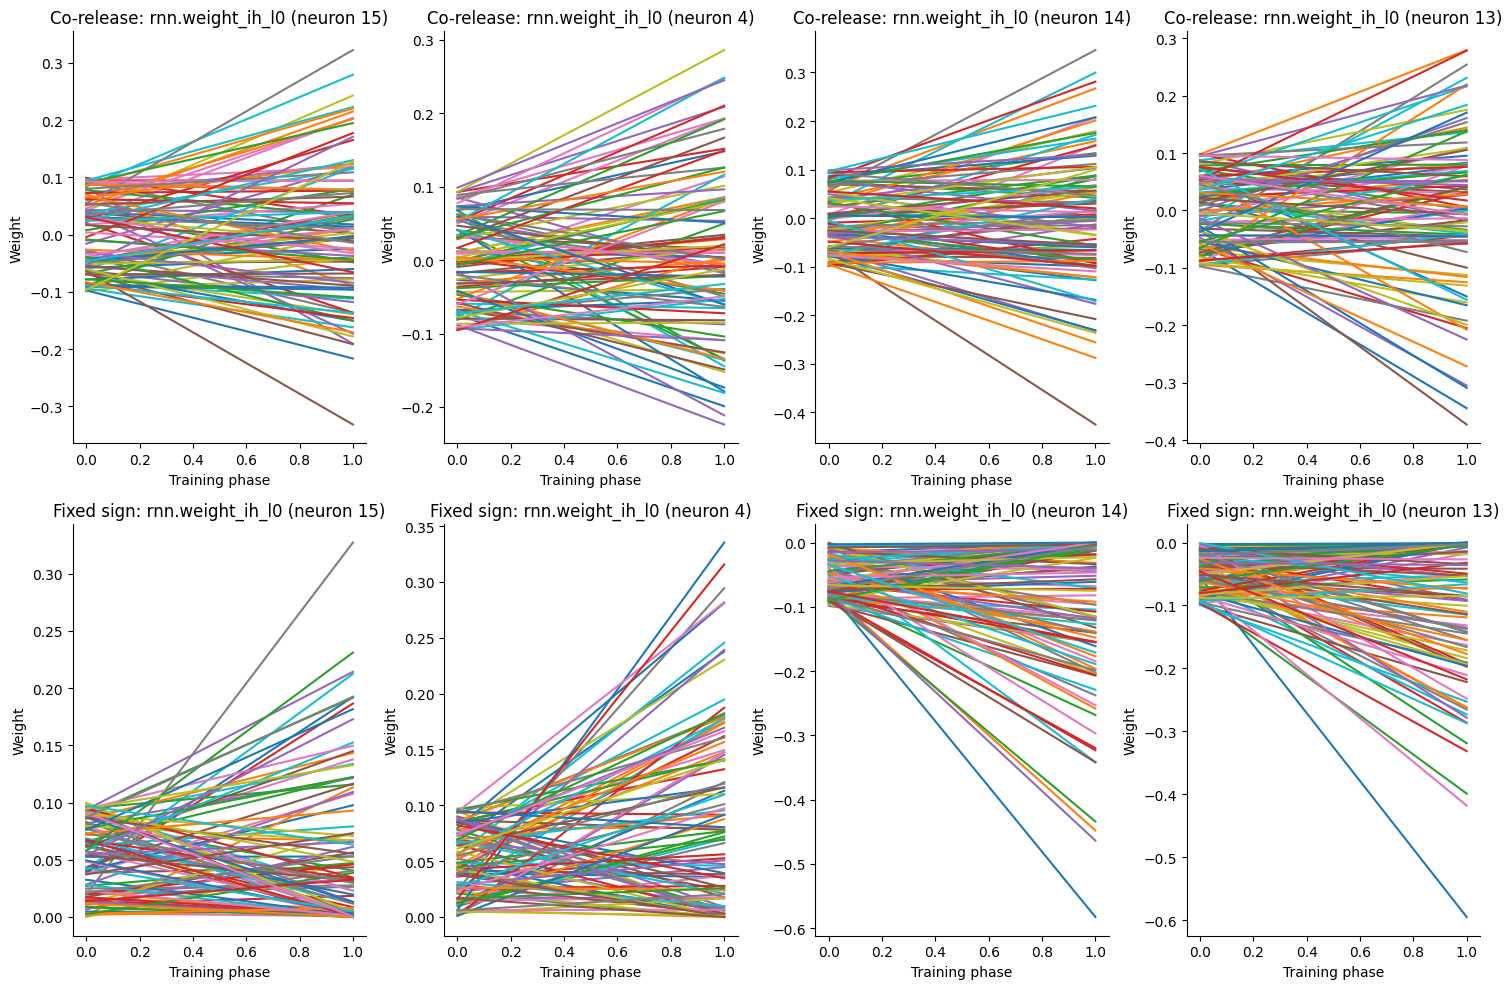

In [28]:
# Plot flipped EP neuron weight changes
n_row = 2
n_col = 4

fig, axs = plt.subplots(n_row,n_col,figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

key = list(initial_params_corelease)[0]
picked_neurons = torch.randint(1,input_size,(n_col,))

for i, neuron in enumerate(picked_neurons):
    weight_history_corelease = [initial_params_corelease[key][:,neuron].flatten(),
                                trained_params_corelease[key][:,neuron].flatten()]

    weight_history_fixed = [initial_params_fixed[key][:,neuron].flatten(),
                            trained_params_fixed[key][:,neuron].flatten()]

    axs.flatten()[i].plot(weight_history_corelease)
    axs.flatten()[i].set_xlabel('Training phase')
    axs.flatten()[i].set_ylabel('Weight')
    axs.flatten()[i].set_title('Co-release: %s (neuron %d)' %(key, neuron))
    axs.flatten()[i+n_col].plot(weight_history_fixed)
    axs.flatten()[i+n_col].set_xlabel('Training phase')
    axs.flatten()[i+n_col].set_ylabel('Weight')
    axs.flatten()[i+n_col].set_title('Fixed sign: %s (neuron %d)' %(key, neuron))

plt.tight_layout()
plt.show()